In [2]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
import time
import torchvision
import torchvision.transforms as transforms
import matplotlib.cm as cm
import matplotlib as mpl


import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from CNN import CNN
import similarities

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

sim cosine
using device: cuda
epoch 99 || avg loss: 0.15 || grad time elapsed: 0.1 s0.0138s/batch)
time elapsed: 0.25 min
(1000,)
sim dot
using device: cuda
epoch 99 || avg loss: 0.11 || grad time elapsed: 0.1 s0.0141s/batch)
time elapsed: 0.23 min
(1000,)
sim proj
using device: cuda
epoch 99 || avg loss: 0.11 || grad time elapsed: 0.1 s0.0166s/batch)
time elapsed: 0.22 min
(1000,)
sim eucl-L2
using device: cuda
epoch 99 || avg loss: 0.14 || grad time elapsed: 0.1 s0.0136s/batch)
time elapsed: 0.25 min
(1000,)


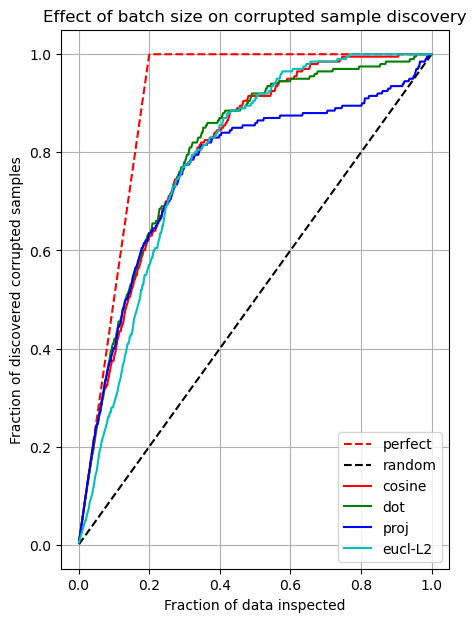

In [9]:
res = {'sim': [], 'p_corr':[]} 
for sim, name in zip([similarities.cosine_similarity(), similarities.dot_product(), similarities.scalar_projection(), similarities.C_dist(L=2, unit_norm=True)], ['cosine', 'dot', 'proj','eucl-L2']): 
    print('sim', name)
    model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())
    dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)

    tic = time.time() 
    vals_dvgs, _ = dvgs.run(crit          = torch.nn.BCELoss(), 
                            similarity     = sim, 
                            optim          = torch.optim.Adam, 
                            lr             = 1e-3, 
                            num_epochs     = 100, 
                            compute_every  = 1,
                            batch_size     = 400, 
                            num_workers    = 1, 
                            grad_params    = None, 
                            verbose        = True, 
                            use_cuda       = True)
    print()
    print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

    pk, p_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs.mean(axis=1), noise_idx, train_size=1000, noise_prop=0.2)
    res['sim'].append(name)
    res['p_corr'].append(p_corr)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'r--', label='perfect')
plt.plot(pk, p_random, 'k--', label='random')

for ii,(sim, cc) in enumerate(zip(res['sim'], ['r', 'g', 'b', 'c'])):
    plt.plot(pk, res['p_corr'][ii], color=cc, label=sim, linestyle='solid')

plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.legend()
plt.grid(b=None)
plt.title('Effect of batch size on corrupted sample discovery')
plt.show()